In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
import os
import chainer
from chainer.dataset import convert
import cv2
import net_conv
import hickle as hkl

In [2]:
# Data input-output variables
# path to dataset hkl files
PATH = 'D:/ShareData/kitti_data/kitti_hkl/'
# output path
out = 'results/kitti'

In [3]:
# load training, validation and test data
X_train = hkl.load(PATH + 'X_train.hkl')
X_train = X_train / 255.
X_train = X_train.astype('float32')
sources_train = hkl.load(PATH + 'sources_train.hkl')

X_val = hkl.load(PATH + 'X_val.hkl')
X_val = X_val / 255.
X_val = X_val.astype('float32')
sources_val = hkl.load(PATH + 'sources_val.hkl')

X_test = hkl.load(PATH + 'X_test.hkl')
X_test = X_test / 255.
X_test = X_test.astype('float32')
sources_test = hkl.load(PATH + 'sources_test.hkl')

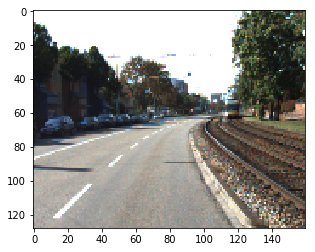

In [4]:
plt.imshow(X_train[0])

In [5]:
input_shape_0 = X_train[0].shape[0]
input_shape_1 = X_train[0].shape[1]
gpu = -1
dimz = 2
batchsize = 16
epoch = 20
initmodel = ''
resume = ''
is_test = False #'store_true'

In [6]:
print('GPU: {}'.format(gpu))
print('# dim z: {}'.format(dimz))
print('# Minibatch-size: {}'.format(batchsize))
print('# epoch: {}'.format(epoch))
print('')

GPU: -1
# dim z: 2
# Minibatch-size: 16
# epoch: 20



In [7]:
# Initialize / Resume
if initmodel:
    chainer.serializers.load_npz(initmodel, model)
if resume:
    chainer.serializers.load_npz(resume, optimizer)

In [9]:
train = list()
for idx in range(len(X_train)-1):
    if sources_train[idx] == sources_train[idx+1]:
        train.append((np.transpose(X_train[idx], (2,0,1)), np.transpose(X_train[idx+1], (2,0,1))))

In [10]:
len(train)

41339

In [11]:
val = list()
for idx in range(len(X_val)-1):
    if sources_val[idx] == sources_val[idx+1]:
        val.append((np.transpose(X_val[idx], (2,0,1)), np.transpose(X_val[idx+1], (2,0,1))))

In [12]:
len(val)

153

In [13]:
test = list()
for idx in range(len(X_test)-1):
    test.append(np.transpose(X_test[idx], (2,0,1)))

In [14]:
random.shuffle(train)
random.shuffle(val)

In [15]:
if is_test:
    train, _ = chainer.datasets.split_dataset(train, 100)
    val, _ = chainer.datasets.split_dataset(val, 100)
train_count = len(train)
val_count = len(val)

train_iter = chainer.iterators.SerialIterator(train, batchsize)
val_iter = chainer.iterators.SerialIterator(val, batchsize, repeat=False, shuffle=False)

In [16]:
model = net_conv.ConvAE_mini(input_shape_0=input_shape_0, input_shape_1=input_shape_1, channel_size=3, n_filters=10, n_latent=dimz, filter_size=3, activation='relu')

# Setup an optimizer
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

In [19]:
c = 1
while train_iter.epoch < epoch:
    sum_loss = 0
    batch = train_iter.next()
    x_array_0 = convert.concat_examples(list(map(lambda X_train: X_train[0], batch)), gpu)
    x_array_1 = convert.concat_examples(list(map(lambda X_train: X_train[1], batch)), gpu)
    x = chainer.Variable(x_array_0)
    # Update model based on the loss function
    # defined by model.get_loss_func()
    optimizer.update(model.get_loss_func(), x, x_array_1)
    sum_loss += float(model.loss.data) * len(x.data)
    if train_iter.is_new_epoch:
        print(c)
        c += 1
        print('train mean loss={}'.format(sum_loss / train_count))
        # evaluation
        sum_loss = 0
        for batch in val_iter:
            x_array_0 = convert.concat_examples(list(map(lambda x: x[0], batch)), gpu)
            x_array_1 = convert.concat_examples(list(map(lambda x: x[1], batch)), gpu)
            x = chainer.Variable(x_array_0)
            loss_func = model.get_loss_func(k=10)
            loss_func(x, x_array_1)
            sum_loss += float(model.loss.data) * len(x.data)
        val_iter.reset()
        print('val mean loss={}'.format(sum_loss / val_count))

1
train mean loss=11.78234536394204
val mean loss=31349.142782373365
2
train mean loss=11.084685466508624
val mean loss=31361.094184027777
3
train mean loss=12.45015375916205
val mean loss=31357.86887254902
4
train mean loss=12.19584865381359
val mean loss=31354.477877348858
5
train mean loss=11.555555891531
val mean loss=31334.13444648693
6
train mean loss=12.116711821766371
val mean loss=31361.499489379086
7
train mean loss=11.801302190425506
val mean loss=31345.21537990196
8
train mean loss=11.62103355789932
val mean loss=31347.448988970587
9
train mean loss=11.470363942040205
val mean loss=31308.21061836193
10
train mean loss=11.524639263165534
val mean loss=31329.82235498366
11
train mean loss=11.94595675391277
val mean loss=31297.030854268793
12
train mean loss=12.819628558987882
val mean loss=31286.183121425653
13
train mean loss=12.149839588524154
val mean loss=31268.06560202206
14
train mean loss=11.588159032632623
val mean loss=31259.230851715685
15
train mean loss=11.3394857

In [21]:
# Save the model and the optimizer
# Check if folder exist 
if not os.path.exists(out):
    os.makedirs(out)
    print('created ', out)
    
print('save the model')
chainer.serializers.save_npz(os.path.join(out, 'model.model'), model)
print('save the optimizer')
chainer.serializers.save_npz(os.path.join(out, 'state.state'), optimizer)

created  results/kitti
save the model
save the optimizer


In [ ]:
# Visualize the results
def save_images(x, filename):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(3, 3, figsize=(9, 9), dpi=100)
    for ai, xi in zip(ax.flatten(), x):
        ai.imshow(np.transpose(xi, (1,2,0)))
    fig.savefig(filename)

In [ ]:
model.to_cpu()
train_ind = np.random.randint(0,len(train),9)
# train_ind = [0,1,2,3,4,5,6,7,8]
batch = np.asarray(train)[train_ind]
x_array_0 = convert.concat_examples(list(map(lambda x: x[0], batch)), gpu)
x_array_1 = convert.concat_examples(list(map(lambda x: x[1], batch)), gpu)
x = chainer.Variable(x_array_0)
with chainer.using_config('train', False), chainer.no_backprop_mode():
    x1 = model(x)
save_images(x_array_0, os.path.join(out, 'train_x'))
save_images(x_array_1, os.path.join(out, 'train_xnext'))
save_images(x1.data, os.path.join(out, 'train_xnext_reconstructed'))

# test_ind = np.random.randint(0,len(test),9)
test_ind = [0,1,2,3,4,5,6,7,8]
batch = np.asarray(test)[test_ind]
x_array_0 = convert.concat_examples(list(map(lambda x: x[0], batch)), gpu)
x_array_1 = convert.concat_examples(list(map(lambda x: x[1], batch)), gpu)
x = chainer.Variable(x_array_0)
with chainer.using_config('train', False), chainer.no_backprop_mode():
    x1 = model(x)
save_images(x_array_0, os.path.join(out, 'train_x'))
save_images(x_array_1, os.path.join(out, 'train_xnext'))
save_images(x1.data, os.path.join(out, 'train_xnext_reconstructed'))


plot for paper (same format with Prednet)

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
#matplotlib.use('Agg')
import matplotlib.gridspec as gridspec

In [ ]:
len(test)

In [ ]:
# test_ind = [0,1,2,3,4,5,6,7,8,9]
test_ind = list(np.linspace(0, len(test)-2, len(test)-1, dtype='int32'))
batch = np.asarray(test)[test_ind]
# test_ind = list(np.linspace(0, 9, 10, dtype='int32'))
# batch = np.asarray(test_glider)[test_ind]
x_array_0 = convert.concat_examples(list(map(lambda x: x, batch)), gpu)
X_train = chainer.Variable(x_array_0)
with chainer.using_config('train', False), chainer.no_backprop_mode():
    x1 = model(x)

In [ ]:
x_array_0.transpose(0,2,3,1).shape

In [ ]:
X_test = x_array_0[:10].transpose(0,2,3,1).reshape(int(x_array_0.data.shape[0]/10), 10, input_shape_0, input_shape_1, 3)
X_hat = x1.data[:10].transpose(0,2,3,1).reshape(int(x_array_0.data.shape[0]/10), 10, input_shape_0, input_shape_1, 3)

In [ ]:
X_test.shape

In [ ]:
nt = 10
aspect_ratio = 0.8
# plt.figure(figsize = (nt, 2*aspect_ratio))
plt.figure(figsize = (100/7.2, 16/7.2))
gs = gridspec.GridSpec(2, nt)
gs.update(wspace=0., hspace=0.)
plot_save_dir = 'fig_for_paper/KITTI/'

if not os.path.eX_trainists(plot_save_dir): 
    os.mkdir(plot_save_dir)
    print("created", plot_save_dir)
    
plot_idx = np.random.permutation(X_test.shape[0])

for i in plot_idx:
    for t in range(nt):     
        plt.subplot(gs[t])
        plt.imshow(X_test[i,t], interpolation='none')
        plt.tick_params(axis='both', which='both', bottom='off', top='off', left='off', right='off', labelbottom='off', labelleft='off')
        if t==0: plt.ylabel('Actual', fontsize=10)

        plt.subplot(gs[t + nt])
        if t % 10 == 0:
            plt.imshow(np.zeros(X_hat[0,0].shape), interpolation='none')
        else:
            plt.imshow(X_hat[i,t-1], interpolation='none')
        plt.tick_params(axis='both', which='both', bottom='off', top='off', left='off', right='off', labelbottom='off', labelleft='off')
        if t==0: plt.ylabel('Predicted', fontsize=10)
    
    plt.savefig(plot_save_dir +  'plot_' + str(i) + '.png')
    plt.clf()
plt.close()

In [ ]:
mse_model = 0
mse_prev = 0
c = 0
for i in range(len(X_test)):
    for j in range(len(X_test[0])-1):
        mse_model += np.mean((X_test[i,j+1,:,:] - X_hat[i,j,:,:])**2)
        mse_prev += np.mean((X_test[i,j+1,:,:] - X_test[i,j,:,:])**2)        
        c += 1

In [ ]:
mse_model/c

In [ ]:
mse_prev/c